In [3]:
import sys
sys.path.append('../numpy')
 
from common.time_layers import (TimeEmbedding, TimeAffine,
                                TimeGRU, TimeSoftmaxWithLoss)
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x_train = np.loadtxt('dataset/x_train.txt', dtype=int)
t_train = np.loadtxt('dataset/t_train.txt', dtype=int)
x_test = np.loadtxt('dataset/x_test.txt', dtype=int)
t_test = np.loadtxt('dataset/t_test.txt', dtype=int)
char_to_id = np.load('dataset/char_to_id.npy', allow_pickle=True).item()
id_to_char = np.load('dataset/id_to_char.npy', allow_pickle=True).item()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

In [5]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt

from common.time_layers import TimeEmbedding, TimeAffine, \
                               TimeGRU, TimeSoftmaxWithLoss
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq

class GruEncoder:
    '''
    GRU-based encoder
    '''
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        embed_W = (np.random.randn(V, D) / np.sqrt(V)).astype('f')
        gru_Wx = (np.random.randn(D, 3*H) / np.sqrt(D)).astype('f')
        gru_Wh = (np.random.randn(H, 3*H) / np.sqrt(H)).astype('f')
        gru_b = np.zeros(3*H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeGRU(gru_Wx, gru_Wh, gru_b, stateful=False)

        self.params = self.embed.params + self.rnn.params
        self.grads = self.embed.grads + self.rnn.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.rnn.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        dout = self.rnn.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class PeekyGruDecoder:
    '''
    GRU-based peeky decoder
    '''
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / np.sqrt(V)).astype('f')
        gru_Wx = (rn(H + D, 3*H) / np.sqrt(H + D)).astype('f')
        gru_Wh = (rn(H, 3*H) / np.sqrt(H)).astype('f')
        gru_b = np.zeros(3*H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeGRU(gru_Wx, gru_Wh, gru_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.rnn, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        self.rnn.set_state(h)
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.rnn.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.rnn.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.rnn.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.rnn.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)
            out = np.concatenate((peeky_h, out), axis=2)
            out = self.rnn.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)
            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

class PeekyGruSeq2seq(Seq2seq):
    '''
    GRU-based peeky seq2seq model
    '''
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = GruEncoder(V, D, H)
        self.decoder = PeekyGruDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.60
| epoch 1 |  iter 21 / 351 | time 2[s] | loss 2.31
| epoch 1 |  iter 41 / 351 | time 3[s] | loss 1.98
| epoch 1 |  iter 61 / 351 | time 5[s] | loss 1.82
| epoch 1 |  iter 81 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 101 / 351 | time 9[s] | loss 1.73
| epoch 1 |  iter 121 / 351 | time 11[s] | loss 1.71
| epoch 1 |  iter 141 / 351 | time 13[s] | loss 1.71
| epoch 1 |  iter 161 / 351 | time 15[s] | loss 1.69
| epoch 1 |  iter 181 / 351 | time 17[s] | loss 1.67
| epoch 1 |  iter 201 / 351 | time 19[s] | loss 1.65
| epoch 1 |  iter 221 / 351 | time 21[s] | loss 1.62
| epoch 1 |  iter 241 / 351 | time 23[s] | loss 1.59
| epoch 1 |  iter 261 / 351 | time 25[s] | loss 1.56
| epoch 1 |  iter 281 / 351 | time 27[s] | loss 1.52
| epoch 1 |  iter 301 / 351 | time 29[s] | loss 1.48
| epoch 1 |  iter 321 / 351 | time 31[s] | loss 1.45
| epoch 1 |  iter 341 / 351 | time 33[s] | loss 1.42
Q 77+85  
T 162 
X 155 
---
Q 975+164
T 1139
X 1011
---
Q 

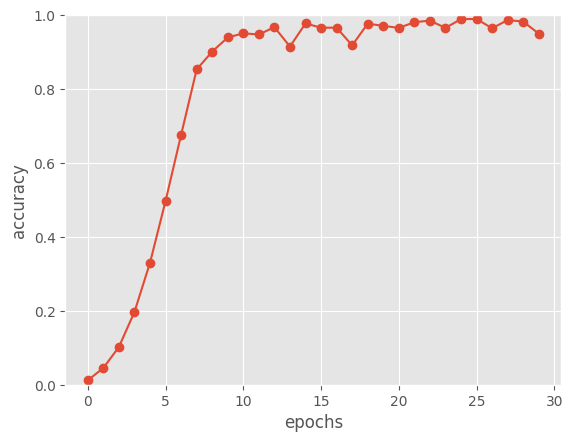

In [6]:
# set hyper-parameters
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 30
max_grad = 5.0

# generate model
model = PeekyGruSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# train
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, 
                                    is_reverse=is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# plot the accuracy (on the test data) over epochs
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()